* author : Cyan Yong Ho Jo
* Python : 3.9.18

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import sys
from iminuit import Minuit

In [3]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH, simpson38
from ExternalFunctions import nice_string_output, add_text_to_ax 

In [4]:
np.random.seed(75)

In [5]:
COLOUR = ['#1E90FF', # 0 # Dodgerblue
          '#FFBF00', # 1 # Amber
          '#FF6347', # 2 # Tomato
          '#00A86B', # 3 # Jade
          '#8A2BE2', # 4 # Blueviolet
          '#FF6FFF', # 5 # Ultra Pink
          '#00CCFF', # 6 # Vivid Sky Blue
          '#FFD800', # 7 # School Bus Yellow
          '#FF004F', # 8 # Folly
          '#0063A6', # 9 # Lapis Lazuli
        ]
def setMplParam(classNum):
    # Define effective colors, line styles, and markers based on the class number
   
    LINE = ['-', '-.', '--', '-.', ':','--','-.','-', ':', '--']
    MARKER = ['.','*', '^', 's', '.', 'p', 'o', 's', '.', 'd']
    COLOUR_EFF = COLOUR[:classNum]
    LINE_EFF = LINE[:classNum]
    MARKER_EFF = MARKER[:classNum]

    # Set the color cycle for lines including color, line style, and marker
    plt.rcParams['axes.prop_cycle'] = (plt.cycler(color=COLOUR_EFF) +
                                       plt.cycler(linestyle=LINE_EFF)+
                                       plt.cycler(marker=MARKER_EFF))

    # Set default line and marker sizes
    plt.rcParams['lines.markersize'] = 3  # Example size
    plt.rcParams['lines.linewidth'] = 2   # Example width for lines

    # Set label and title sizes
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.titlesize'] = 20

    # Set tick properties
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.labelsize'] = 20

    # Set legend font size
    plt.rcParams['legend.fontsize'] = 12

    # Enable and configure grid
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.8
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.linewidth'] = 1

    # Set axes line width
    plt.rcParams['axes.linewidth'] = 2

    # Set tick sizes and widths
    plt.rcParams['xtick.major.size'] = 7
    plt.rcParams['xtick.major.width'] = 3
    plt.rcParams['xtick.minor.size'] = 2
    plt.rcParams['xtick.minor.width'] = 2

    plt.rcParams['ytick.major.size'] = 7
    plt.rcParams['ytick.major.width'] = 3
    plt.rcParams['ytick.minor.size'] = 2
    plt.rcParams['ytick.minor.width'] = 2

setMplParam(10)


# Ex1

* Neutrino energy distribution depends on the mass of the black hole from which the neutrinos originate
* The range of the energy is fixed as `E = np.linspace(1, 100, 100)` within the scope of Ex1

* `getTfromM` returns the corresponding temperature(in $GeV$) for the passed mass(in $g$) 
  * the order of magnitude of `T` is 10
  * it is a good idea to work in `T` domain than `M` as the computer would suffer less scaling problem
* `testTemperature` displays the temperatures for given masses in the example

In [6]:
def getTfromM(M):
    C = 1.057e13
    return C / M

def getMfromT(T):
    return getTfromM(T)

def testTemperature():
    M = np.array([2.5e11, 4e11, 9e11])
    T = getTfromM(M)
    print('| M | T |')
    print('|---|---|')
    for m, t in  zip(M, T):
        print(f'| {m:.1e} | {t:1.2f} |')
testTemperature()

| M | T |
|---|---|
| 2.5e+11 | 42.28 |
| 4.0e+11 | 26.43 |
| 9.0e+11 | 11.74 |


In [7]:
def convertScientificNumber(number):
    # Split the number into its base and exponent parts
    base, exponent = f"{number:.2e}".split('e')
    # Adjust the exponent to remove leading '+', and format for LaTeX
    exponent = int(exponent)  # Convert exponent to integer to remove leading '+'
    return f"${base} \\times 10^{{{exponent}}}$"  # LaTeX formatting


* `neutrinoEnergyDistribution` is a primordial function for the energy distribution of the neutrinos. 
* Different energy distribution for different temperature and thus different mass
* free variable : `E`

In [8]:
E = np.linspace(0, 400, 1000)

In [9]:
def neutrinoEnergyDistribution(E, T):
    k = np.exp(E/T)
    return (k-1) / (k+3) / (k+1)

* `plotNeutrinoEnergyDistribution` is used to investigate the shape and scale of the primordial energy distribution function
* The selection of energy range
    * `E = np.linspace(0, 400, 1000)` for T = 50 seems OK
    * `E = np.linspace(0, 100, 1000)` for T = 10 seems OK but not neough for T = 50

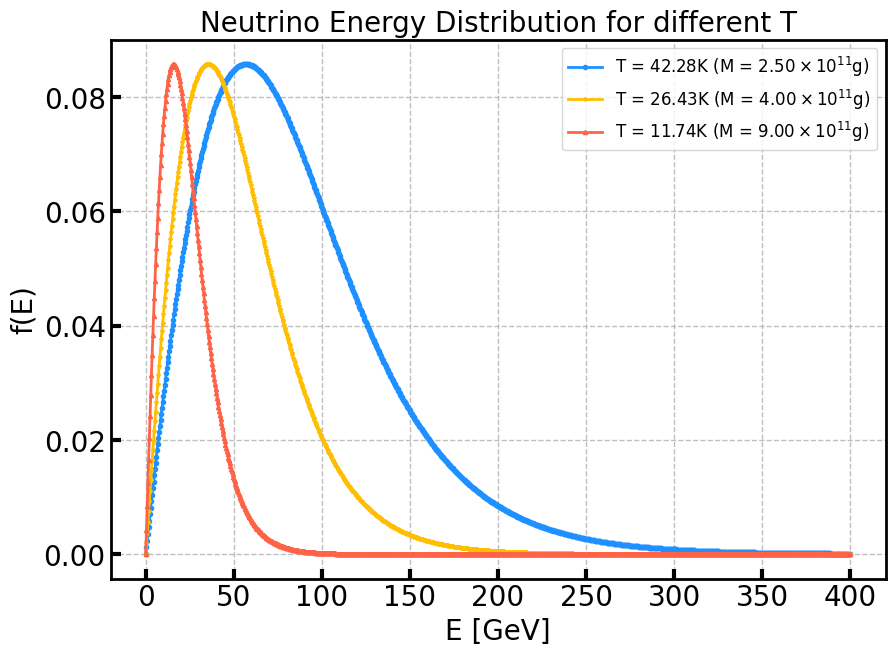

In [10]:
def plotNeutrinoEnergyDistribution(E):
    M = np.array([2.5e11, 4e11, 9e11])
    T = getTfromM(M)
    fig, ax = plt.subplots(figsize=(10, 7))
    for m, t in  zip(M, T):
        label = f'T = {t:1.2f}K (M = {convertScientificNumber(m)}g)'
        ax.plot(E, neutrinoEnergyDistribution(E, t), label=label, linestyle='-')
    ax.set_title(f'Neutrino Energy Distribution for different T')
    ax.set_xlabel('E [GeV]')
    ax.set_ylabel('f(E)')
    ax.legend()

plotNeutrinoEnergyDistribution(E)

* `getArea` returns the area of the passed distribution function for given `T`
  * `dist` is an energy distribution
  * Monte Carlo method with scale `N` 
  * **This function introduces randomness. It needs to be fixed to one value.**

In [11]:
def getArea(dist, x, *args):
    # REPRODUCIBILITY!
    np.random.seed(75)

    # consistently use this energy range 
    x_min = x.min()
    x_max = x.max()

    y = dist(x, *args)
    y_min = 1e-10
    y_max = y.max()
    N = 100_000
    x_random = np.random.uniform(x_min, x_max, N)
    y_random = np.random.uniform(y_min, y_max, N)
    y_random = y_random[y_random < dist(x_random, *args)]
    accepted = len(y_random)
    area = (x_max - x_min) * (y_max - y_min) * accepted / N
    return area

* `pdfNeutrino` is the pdf, normalised neutrino energuy distribution  
  * exception handling: when area of the distribution is too small

In [12]:
def pdfNeutrino(E, T):
    area = getArea(neutrinoEnergyDistribution, E, T)
    area = max(area, 1e-10)
    
    return neutrinoEnergyDistribution(E, T) / area

In [13]:
# Return a function depending only on x.
def make_f(f, *args):
    return lambda x: f(x, *args)

* `plotNeutrinoPdf` is used to investigate the shape and scale of the pdf

area(t=42.28K) = 0.9995
area(t=26.43K) = 1.0020
area(t=11.74K) = 1.0259


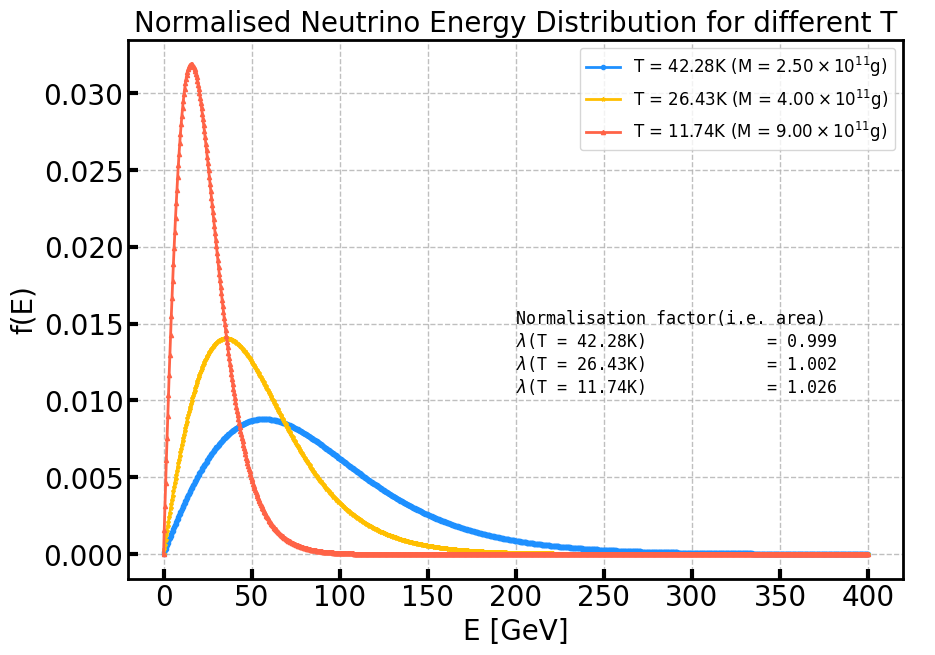

In [14]:
def plotNeutrinoPdf():
    E = np.linspace(0, 400, 1000)
    M = np.array([2.5e11, 4e11, 9e11])
    T = getTfromM(M)
    d = {'Normalisation factor(i.e. area)': '',}
    fig, ax = plt.subplots(figsize=(10, 7))
    for m, t in  zip(M, T):
        label = f'T = {t:1.2f}K (M = {convertScientificNumber(m)}g)'
        print(f'area(t={t:1.2f}K) = {getArea(pdfNeutrino, E, t):.4f}')
        ax.plot(E, pdfNeutrino(E, t), label=label, linestyle='-')
        d[f'$\lambda$(T = {t:1.2f}K)'] = f'= {getArea(pdfNeutrino, E, t):.3f}'
    ax.set_title(f'Normalised Neutrino Energy Distribution for different T')
    ax.set_xlabel('E [GeV]')
    ax.set_ylabel('f(E)')
    ax.legend()
    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.5, 0.5, text, ax, fontsize=12, color='k')

plotNeutrinoPdf()

* `readData` reads the data file and return the data in pandas DataFrame

In [15]:
def readData():
    filename = 'resources/neutrino_energies.csv'
    df = pd.read_csv(filename, sep=' ', header=None, skiprows=1)
    df = pd.DataFrame(df[0].astype(float))
    df.columns = ['E']
    return df

* `getHistoParam` returns the histogram parameters for given data
  * `Nbins`, `counts`, `binwidth`, `x_centres`

In [16]:
def getHistoParam(data):
    Nbins = int(np.sqrt(data.shape[0]))
    counts, x_edges = np.histogram(data, bins=Nbins)
    binwidth = x_edges[1] - x_edges[0]
    x_centres = x_edges[:-1] + binwidth/2
    return Nbins, binwidth, counts, x_centres

* `plotHistogram` plots histogram of passed data using the parameters by `getHistoParam`
  * `Nbins`, `counts`, `binwidth`, `x_centres`

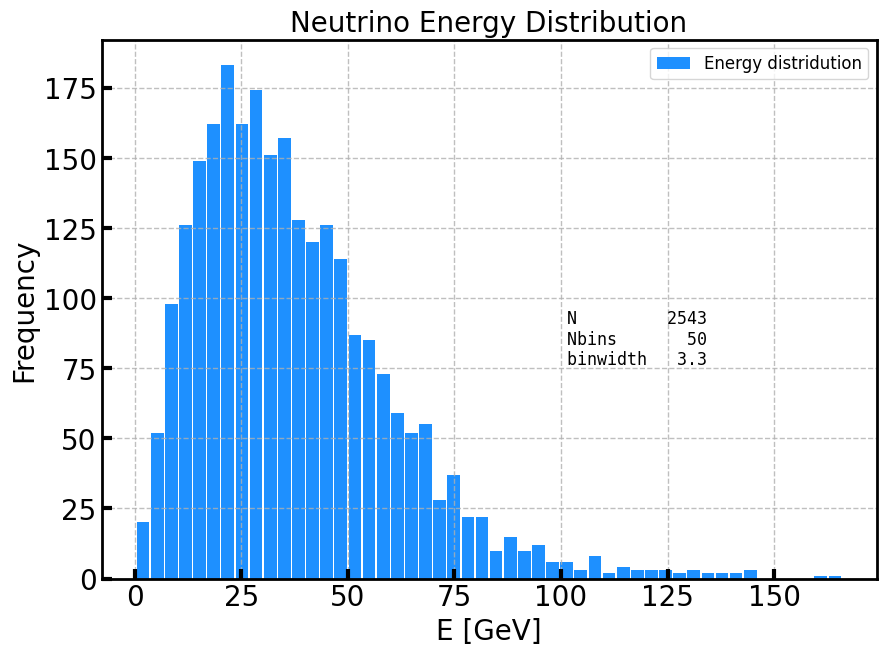

In [17]:
def plotHistogram(data):
    Nbins, binwidth, _, _ = getHistoParam(data)
    # plot the histogram
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.hist(data, bins=Nbins, label='Energy distridution', rwidth=0.9)
    
    ax.set_title('Neutrino Energy Distribution')
    ax.set_xlabel('E [GeV]')
    ax.set_ylabel('Frequency')
    ax.legend()
    d = {'N': len(data), 'Nbins': Nbins, 'binwidth': f'{binwidth:.1f}'}
    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.6, 0.5, text, ax, fontsize=12, color='k')

plotHistogram(readData())

* `getScaledPdf` returns the functional object that is scaled with the size of the data and the binwidth from `getHistoParam`

In [18]:
def getScaledPdf(f, data, *args):
    Ndata = data.shape[0]
    _, binwidth, _, _ = getHistoParam(data)
    scaleFactor = Ndata * binwidth

    # Define a new function that applies the scaling factor to the output of f
    def scaled_f(x, *args):
        return f(x, *args) * scaleFactor

    return scaled_f

* `plotBoth` function generates a histogram of the data and overlays it with the corresponding scaled PDFs for comparison.
* the plot hints that the mass of the black hole lies between $4.0\times10^{11}$ and $9.0\times10^{11}$
* My intuition urges me to insist that $M_{BH} \sim 6.0\times10^{11}$

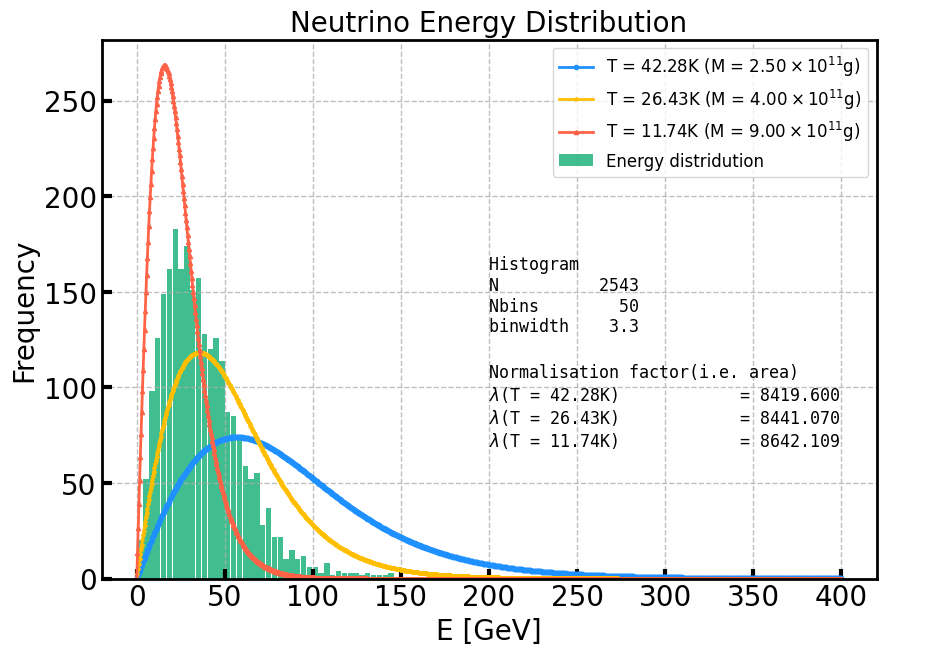

In [19]:
def plotHistoAndScaled(isMin = False, T_min = None, TitleTag = None):
    fig, ax = plt.subplots(figsize=(10, 7))
    df = readData()
    data = df['E']

    ##------------pdf plot
    E = np.linspace(0, 400, 1000)
    M = np.array([2.5e11, 4e11, 9e11])
    T = getTfromM(M)

    d_pdf = {'Normalisation factor(i.e. area)': '',}
    for m, t in  zip(M, T):
        scaledPdf = getScaledPdf(pdfNeutrino, data, t)
        label = f'T = {t:1.2f}K (M = {convertScientificNumber(m)}g)'
        ax.plot(E, scaledPdf(E, t), label=label, linestyle='-')
        d_pdf[f'$\lambda$(T = {t:1.2f}K)'] = f'= {getArea(scaledPdf, E, t):.3f}'
    text_pdf = nice_string_output(d_pdf, extra_spacing=2, decimals=3)
    add_text_to_ax(0.50, 0.4, text_pdf, ax, fontsize=12, color='k')
    
    ##------------histogram plot
    # handle the binning
    Nbins, binwidth, _, _ = getHistoParam(data)

    # plot the histogram
    ax.hist(data, bins = Nbins, label='Energy distridution',alpha = 0.75, rwidth=0.9)
    
    d_hist = {'Histogram': '','N': len(data), 'Nbins': Nbins, 'binwidth': f'{binwidth:.1f}'}
    text_hist = nice_string_output(d_hist, extra_spacing=2, decimals=3)
    add_text_to_ax(0.50, 0.6, text_hist, ax, fontsize=12, color='k')
    ##------------plot minimum
    if isMin:
        d_min = {'MinimumLLH': '',}
        scaledPdf = getScaledPdf(pdfNeutrino, data, T_min)        
        M_min = getMfromT(T_min)
        label_min = f'T = {T_min:1.2f}K (M = {convertScientificNumber(M_min)}g)'
        ax.plot(E, scaledPdf(E, T_min), label=label_min, linestyle='-', markersize=3)
        d_min[f'$\lambda$(T = {T_min:1.2f}K)'] = f'= {getArea(scaledPdf, E, T_min):.3f}'
        text_min = nice_string_output(d_min, extra_spacing=2, decimals=3)
        add_text_to_ax(0.50, 0.2, text_min, ax, fontsize=12, color='k')

    ## ---------------common plot settings
    addtitle = ''
    if TitleTag is not None:
        addtitle = f', LLH minimisation by {TitleTag}'
    ax.set_title('Neutrino Energy Distribution'+addtitle)
    ax.set_xlabel('E [GeV]')
    ax.set_ylabel('Frequency')
    ax.legend()

plotHistoAndScaled()

In [20]:
M_estimate = 6e11
T_estimate = getTfromM(M_estimate)
T_estimate

17.616666666666667

* search a range of T to find an extreme likelihood value
* In case of using ten steps, it took 2m 34sec
  * `T = np.linspace(T_9, T_4, 10)`
* eye estimation : 
  * $M_{BH} = 6\times 10^{11}g$
  * $T_{BH} = 17.62 K$

In [21]:
def llh(pdf, data, *args):
    return -2 * np.sum(np.log(pdf(data, *args)))

In [22]:
def T_range(Nstep):
    T_9 = 11.00 # lower limit
    T_4 = 27.00 # upper limit
    T = np.linspace(T_9, T_4, Nstep)
    return T

In [23]:
def getMinParams(T, L):
    minLLH = np.min(L)
    minLLH_i = np.argmin(L)
    minLLH_T = T[minLLH_i]
    return minLLH, minLLH_T

In [24]:
def UnbinnedLH(Nstep):
    data = readData()['E']
    T = T_range(Nstep)
    L = np.zeros(Nstep)
    for i in range(Nstep):
        L[i] = llh(pdfNeutrino, data, T[i])
    return T, L

* `plotUnbinnedLH` performs 1D Raster scan
* reduce the Monte Carlo scale for normalisation from 100,000 to 10,000
* Execution time
  * $t($`Nstep`$ = 10) =  4.2sec$
  * $t($`Nstep`$ = 100) =  19.9sec$
  * $t($`Nstep`$ = 1000) =  3m 30sec$  (cf. WinPC $3.3sec$)


stepT = 0.02


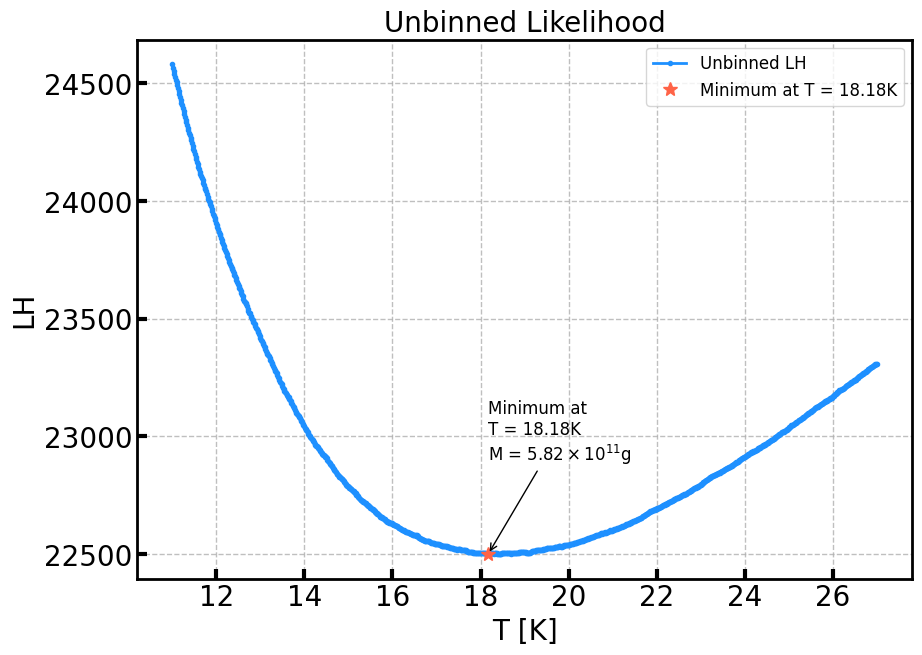

In [25]:
def plotUnbinnedLH():
    Nstep = 1000
    T, L = UnbinnedLH(Nstep)
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.plot(T, L, label='Unbinned LH', linestyle='-')
    ax.set_title('Unbinned Likelihood')
    ax.set_xlabel('T [K]')
    ax.set_ylabel('LH')
    ax.legend()
    minLLH, minLLH_T = getMinParams(T, L)
    minLLH_M = convertScientificNumber(getMfromT(minLLH_T))
    ax.plot(minLLH_T, minLLH, markersize = 10, 
            linestyle = '', c = 'tomato', 
            label=f'Minimum at T = {minLLH_T:1.2f}K')
    ax.annotate(f'Minimum at \nT = {minLLH_T:1.2f}K\nM = {minLLH_M}g',
                xy=(minLLH_T, minLLH), 
                xytext=(minLLH_T, minLLH+400), 
                arrowprops=dict(facecolor='tomato', arrowstyle='->'),
                fontsize=12)
    ax.legend()
    dT = T[1] - T[0]
    return minLLH_T, dT

minLLH_T_Raster, dT_raster = plotUnbinnedLH()
print(f'stepT = {dT_raster:.2f}')

In [26]:
print(f'stepT = {dT_raster:.2f}K')

stepT = 0.02K


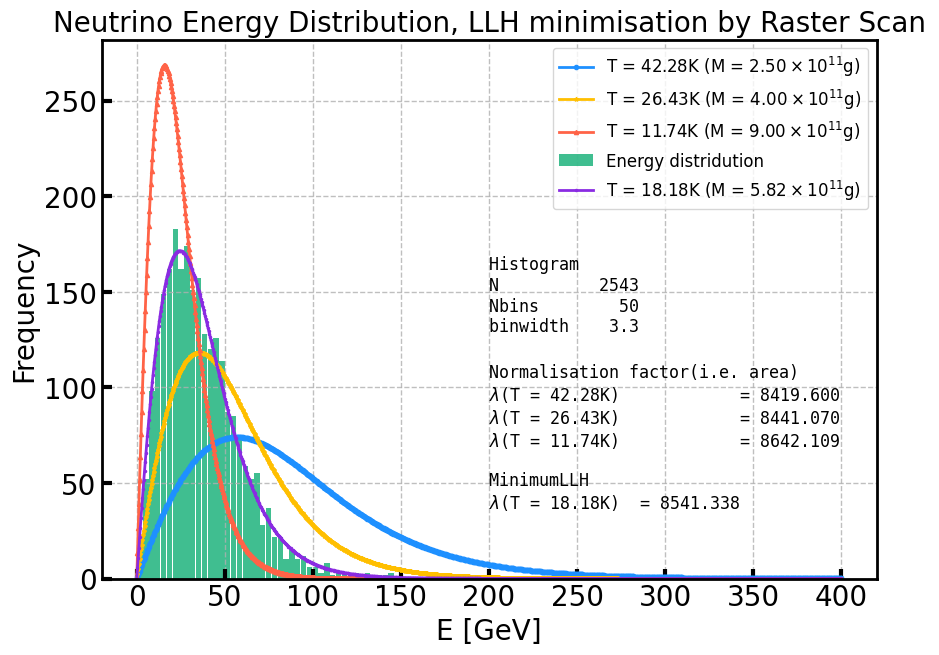

In [27]:
plotHistoAndScaled(True, minLLH_T_Raster, "Raster Scan")

In [28]:
def make_LLH_f(data):
    # Adjusted to directly use 'pdfNeutrino' within 'llh'
    def LLH(T):
        # Directly calculates LLH using 'pdfNeutrino', passing 'T' as part of '*args'
        return llh(pdfNeutrino, data, T)
    return LLH

In [29]:
def minimiseLLH():
    data = readData()['E']
    T = T_range(1000)
    T_min, T_max = 16.0, 20.0
    ## function that is going to be minimised wrt T
    LLH_f = make_LLH_f(data) 
    
    minuit = Minuit(LLH_f, T=T_estimate)
    minuit.limits = (T_min, T_max)
    migrad = minuit.migrad()
    print(migrad)
    print(minuit.values['T'])
    print(minuit.errors['T'])
    return minuit.values['T'], minuit.errors['T']
minLLH_T_Minuit, dT_minuit = minimiseLLH()



┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.25e+04                   │              Nfcn = 148              │
│ EDM = 496 (Goal: 0.0002)         │            time = 1.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

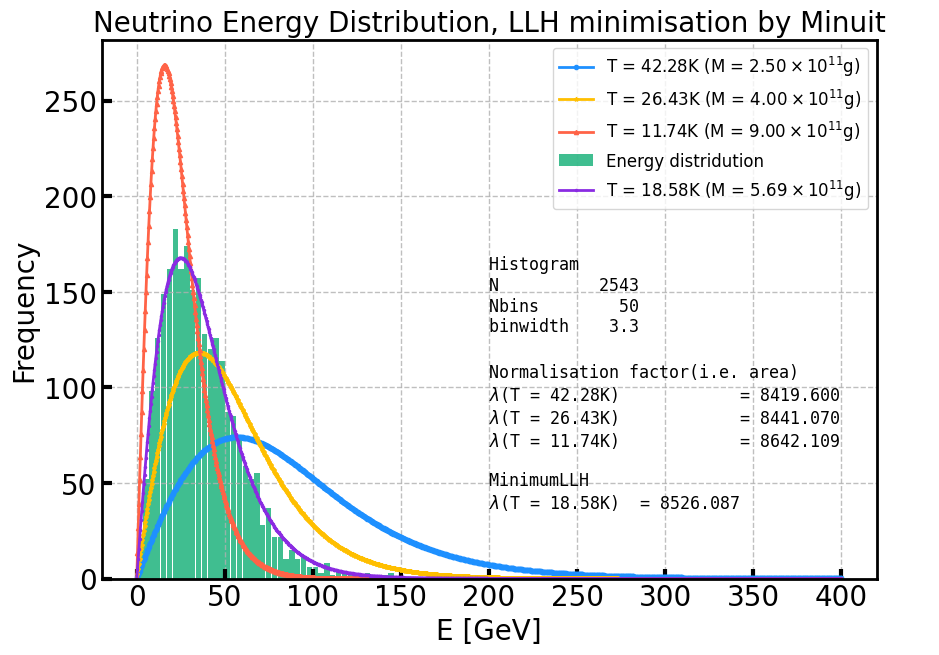

In [30]:
plotHistoAndScaled(True, minLLH_T_Minuit, "Minuit")

In [39]:
def getDeltaM(M, dT):
    C = 1.057e13
    return M**2 *dT / C

In [41]:
def deltaM(T, dT):
    M = getMfromT(T)
    dM = getDeltaM(M, dT)
    print(f'M = {convertScientificNumber(M)}g, dM = {convertScientificNumber(dM)}g')
    
deltaM(minLLH_T_Raster, dT_raster)
deltaM(minLLH_T_Minuit, dT_minuit)

M = $5.82 \times 10^{11}$g, dM = $5.12 \times 10^{8}$g
M = $5.69 \times 10^{11}$g, dM = $5.13 \times 10^{9}$g


In [44]:
def weightedT(T_raster, T_minuit, dT_raster, dT_minuit):
    V = 1/(1/dT_raster**2 + 1/dT_minuit**2)
    print(V)
    T_mean = (T_raster/dT_raster**2 + T_minuit/dT_minuit**2) * V
    M_mean = getMfromT(T_mean)
    dM = getDeltaM(M_mean, np.sqrt(V))
    print('Weighted mean and std. dev. of T and M:')
    print(f'T_mean = {T_mean:.2f}K, dT = {np.sqrt(V):.2f}K')
    print(f'M = {convertScientificNumber(M_mean)}g, dM = {convertScientificNumber(dM)}g')



weightedT(minLLH_T_Raster, minLLH_T_Minuit, dT_raster, dT_minuit)
# T_wei, dT_wei

Weighted mean and std. dev. of T and M:
T_mean = 18.18K, dT = 0.02K
M = $5.81 \times 10^{11}$g, dM = $5.10 \times 10^{8}$g
